**imports**

In [2]:
import spacy
import sklearn
import pathlib
import numpy
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn
import json

from sklearn import metrics
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs


# Data Preprocessing

**Preparing Train Set**

In [3]:
with open('my_tweets.json') as f:
    data = json.load(f)

tweets = []
tweets_target=[]
tweets_topics=[]
for tweet in data.values():
    tweets.append(tweet['text_of_tweet'])
    tweets_target.append(tweet["sentiment_label"])
    tweets_topics.append(tweet["tweet_topic"]) 

In [4]:
#converting the tweets labels from words to numbers for train set labels
for i in range(len(tweets_target)):
    if tweets_target[i] == 'positive':
        tweets_target[i] = 2
    elif tweets_target[i] == 'neutral':
        tweets_target[i] = 1
    elif tweets_target[i] == 'negative':
        tweets_target[i] = 0

In [5]:
# converting word to number label of train set topics
for i in range(len(tweets_topics)):
    if tweets_topics[i] == 'movie':
        tweets_topics[i] = 0
    elif tweets_topics[i] == 'restaurant':
        tweets_topics[i] = 1
    elif tweets_topics[i] == 'book':
        tweets_topics[i] = 2

**Preparing Test Set**

In [6]:
#importing the test set 
import csv
sentences= []
real_labels=[]
test_topics=[]
with open('sentiment-topic-final-test.tsv', 'r') as tsv_file:
    tsv_reader = csv.reader(tsv_file, delimiter='\t')
    next(tsv_reader)  # Skips the first row
    for row in tsv_reader:
        sentences.append(row[1])
        test_topics.append(row[3]) 
        real_labels.append(row[2])

In [7]:
# converting word to number label of test set topics
for i in range(len(test_topics)):
    if test_topics[i] == 'movie':
        test_topics[i] = 0
    elif test_topics[i] == 'restaurant':
        test_topics[i] = 1
    elif test_topics[i] == 'book':
        test_topics[i] = 2

# Sentiment Analysis

**Sentiment Analysis: VADER**

In [8]:
nlp = spacy.load("en_core_web_sm")
vader_model = SentimentIntensityAnalyzer()

def run_vader(textual_unit, 
              lemmatize=True, 
              parts_of_speech_to_consider=None,
              verbose=0):
    doc = nlp(textual_unit)
        
    input_to_vader = []

    for sent in doc.sents:
        for token in sent:

            to_add = token.text

            if lemmatize:
                to_add = token.lemma_

                if to_add == '-PRON-': 
                    to_add = token.text

            if parts_of_speech_to_consider:
                if token.pos_ in parts_of_speech_to_consider:
                    input_to_vader.append(to_add) 
            else:
                input_to_vader.append(to_add)

    scores = vader_model.polarity_scores(' '.join(input_to_vader))
    
    if verbose >= 1:
        print()
        print('INPUT SENTENCE', sent)
        print('INPUT TO VADER', input_to_vader)
        print('VADER OUTPUT', scores)

    return scores

In [9]:
def vader_output_to_label(vader_output):
    compound = vader_output['compound']
    
    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    elif compound > 0.0:
        return 'positive'
    
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0}) == 'neutral'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.01}) == 'positive'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': -0.01}) == 'negative'

In [10]:
labels_predicted_by_vader=[]
    
for sentence in sentences:
    vader_output = run_vader(sentence,lemmatize=True)
    labels_predicted_by_vader.append(vader_output_to_label(vader_output))
    
report = classification_report(real_labels,labels_predicted_by_vader,digits = 3)
print(report)

              precision    recall  f1-score   support

    negative      0.500     0.333     0.400         3
     neutral      0.000     0.000     0.000         3
    positive      0.500     1.000     0.667         4

    accuracy                          0.500        10
   macro avg      0.333     0.444     0.356        10
weighted avg      0.350     0.500     0.387        10



/Users/mac/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Sentiment Analysis: Multinomial Naive Bayes**

In [11]:
#converting the tweets labels from words to numbers for test set labels
for i in range(len(real_labels)):
    if real_labels[i] == 'positive':
        real_labels[i] = 2
    elif real_labels[i] == 'neutral':
        real_labels[i] = 1
    elif real_labels[i] == 'negative':
        real_labels[i] = 0

In [12]:
tweets_vec = CountVectorizer(min_df=2, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed
tweets_counts = tweets_vec.fit_transform(tweets)
tfidf_transformer = TfidfTransformer()
tweets_tfidf = tfidf_transformer.fit_transform(tweets_counts)

/Users/mac/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [13]:
docs_train, docs_test, y_train, y_test = train_test_split(
    tweets_tfidf, # the tf-idf model
    tweets_target, # the category values for each tweet 
    test_size = 0.2 # we use 80% for training and 20% for development
    ) 

clf = MultinomialNB().fit(docs_train, y_train)
y_pred = clf.predict(docs_test)

report = classification_report(real_labels,y_pred,digits = 3)
print(report)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.500     0.667     0.571         3
           2      0.333     0.500     0.400         4

    accuracy                          0.400        10
   macro avg      0.278     0.389     0.324        10
weighted avg      0.283     0.400     0.331        10



/Users/mac/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Sentiment Analysis: Complement Naive Bayes**

In [14]:
docs_train, docs_test, y_train, y_test = train_test_split(
    tweets_tfidf, # the tf-idf model
    tweets_target, # the category values for each tweet 
    test_size = 0.2 # we use 80% for training and 20% for development
    ) 

clf = ComplementNB().fit(docs_train, y_train)
y_pred2 = clf.predict(docs_test)

report = classification_report(real_labels,y_pred2,digits = 3)
print(report)

              precision    recall  f1-score   support

           0      1.000     0.333     0.500         3
           1      1.000     0.667     0.800         3
           2      0.571     1.000     0.727         4

    accuracy                          0.700        10
   macro avg      0.857     0.667     0.676        10
weighted avg      0.829     0.700     0.681        10



**Error Analysis of Sentiment Analysis Models**

In [15]:
sentiment_labels = {2: 'positive', 1: 'neutral', 0: 'negative'}
list1 = [2, 0, 2, 2, 2, 1, 2, 0, 2, 2]
y_pred = [sentiment_labels[i] for i in y_pred]
y_pred2 = [sentiment_labels[i] for i in y_pred2]

In [16]:
sentiment_labels = {2: 'positive', 1: 'neutral', 0: 'negative'}

for i in range(len(real_labels)):
    if real_labels[i] in sentiment_labels:
        real_labels[i] = sentiment_labels[real_labels[i]]

for i in range(len(y_pred)):
    if isinstance(y_pred[i], int) and y_pred[i] in sentiment_labels:
        y_pred[i] = sentiment_labels[y_pred[i]]

for i in range(len(y_pred2)):
    if isinstance(y_pred2[i], int) and y_pred2[i] in sentiment_labels:
        y_pred2[i] = sentiment_labels[y_pred2[i]]

In [17]:
import pandas as pd

data = {
    'sentences': sentences,
    'real_label': real_labels,
    'vader_predicted_label': labels_predicted_by_vader,
    'complementNB_predicted_label': y_pred2,
    'multinomialNB_predicted_label': y_pred
}

df = pd.DataFrame(data)
df

,sentences,real_label,vader_predicted_label,complementNB_predicted_label,multinomialNB_predicted_label
0,It took eight years for Warner Brothers to rec...,negative,negative,positive,positive
1,All the New York University students love this...,positive,positive,positive,neutral
2,This Italian place is really trendy but they h...,negative,positive,negative,positive
3,"In conclusion, my review of this book would be...",positive,positive,positive,positive
4,The story of this movie is focused on Carl Bra...,neutral,positive,neutral,positive
5,Chris O'Donnell stated that while filming for ...,neutral,positive,positive,neutral
6,My husband and I moved to Amsterdam 6 years ag...,positive,positive,positive,neutral
7,Dame Maggie Smith performed her role excellent...,positive,positive,positive,positive
8,The new movie by Mr. Kruno was shot in New Yor...,neutral,negative,neutral,neutral
9,"I always have loved English novels, but I just...",negative,positive,positive,positive


# Topic Analysis

**BERT**

In [14]:
categories = ['movie', 'book', 'restaurant'] 

In [15]:
test = pd.DataFrame({'text': sentences, 'labels': test_topics})

In [16]:
train = pd.DataFrame({'text': tweets, 'labels': tweets_topics})

In [23]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=5 # number of epochs
model_args.train_batch_size=8 # batch size
model_args.learning_rate=1e-5 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [24]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args=model_args, use_cuda=False) # CUDA is enabled

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [25]:
train, dev = train_test_split(train, test_size=0.3, random_state=0, 
                               stratify=train[['labels']])

In [26]:
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/24 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 1 of 5:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 2 of 5:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 3 of 5:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 4 of 5:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


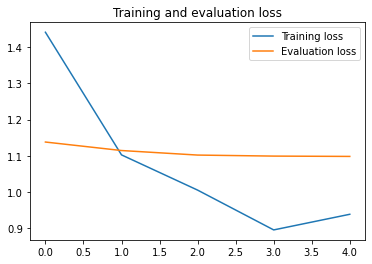

In [27]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [28]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted
print(classification_report(test['labels'], test['predicted']))

  0%|          | 0/10 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         3
           2       0.50      0.50      0.50         2

    accuracy                           0.60        10
   macro avg       0.38      0.50      0.42        10
weighted avg       0.41      0.60      0.48        10



/Users/mac/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
